# Explore Email Dataset

We start with the full Enron email dump (`emails.csv`, ~517k raw messages) and build a
small, workshop-ready subset of emails that already contain rich conversational
context in their quoted history. The goal is to hand facilitators a handful of
messages that:

- revolve around action-oriented language (deadlines, follow ups, approvals)
- keep recipient lists manageable (true conversations, not company-wide blasts)
- include enough quoted history to surface commitments and potential misses
- stay short enough (≤5k characters) for a 60-minute tutorial

Rather than reconstructing threads, we treat each long email as the unit of
analysis. By the end, we will have a scored table (`candidate_df`) packed with the
most useful conversation-heavy emails, ready for manual evaluation and LLM judge
demos.


We cap subject frequency at `MAX_SUBJECT_FREQUENCY = 50` so recurring broadcast topics (e.g., newsletters) don’t dominate the slice.

We apply a deterministic filter stack: `TIME_WINDOW`, `ACTION_KEYWORDS`, `MAX_RECIPIENTS`, `BROADCAST_SUBJECT_KEYWORDS`, `MAX_SUBJECT_FREQUENCY`, `MIN_QUOTE_MARKERS`, and `MAX_BODY_CHARS` to end up with email-sized conversations.

### What We'll Do
- Load the raw Enron CSV and take a quick peek at the MIME payloads.
- Parse headers/body into lightweight features (participants, body length, quote markers).
- Apply a focused filter stack: time window, action keywords, recipient cap, broadcast stoplist, long/quoted requirement, a subject frequency cap, and a 5k character ceiling.
- Inspect distributions and rank the remaining emails by conversational depth.
- Preview the top candidates so facilitators can export them for labeling and evals.


In [1]:
import re
from email.utils import getaddresses, parseaddr
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Markdown, display

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 160)

DATA_PATH = Path("../data/emails.csv")
TIME_WINDOW = (pd.Timestamp("2001-03-01"), pd.Timestamp("2001-06-30"))
ACTION_KEYWORDS = [
    "deadline",
    "deliver",
    "deliverable",
    "please review",
    "fyi",
    "action item",
    "follow up",
    "schedule",
    "update",
    "approve",
]
ACTION_PATTERN = re.compile(
    "|".join(re.escape(k) for k in ACTION_KEYWORDS), flags=re.IGNORECASE
)
BROADCAST_SUBJECT_KEYWORDS = [
    "newsletter",
    "announcement",
    "enron mentions",
    "organizational announcement",
]
MAX_RECIPIENTS = 6
MIN_BODY_CHARS = 800
MIN_QUOTE_MARKERS = 2
MAX_BODY_CHARS = 5000
MAX_SUBJECT_FREQUENCY = 50
plt.style.use("seaborn-v0_8")

## Load raw emails

We ingest the full `emails.csv`, compute quick size stats, and immediately apply a coarse action-keyword + length filter so we only carry interesting messages into later steps.

In [2]:
raw_df = pd.read_csv(DATA_PATH, usecols=["file", "message"]).rename(
    columns={"message": "raw_message"}
)
raw_df["raw_char_len"] = raw_df["raw_message"].str.len()
print(
    f"Loaded {len(raw_df):,} rows (~{raw_df.raw_char_len.sum() / 1e6:,.1f}M characters)"
)

keyword_regex = "|".join(re.escape(k) for k in ACTION_KEYWORDS)
raw_df = raw_df[
    raw_df["raw_message"].str.contains(keyword_regex, case=False, regex=True, na=False)
]
raw_df = raw_df[raw_df["raw_char_len"] >= MIN_BODY_CHARS]
print(f"After quick keyword/length filter: {len(raw_df):,} rows remain")

display(raw_df.head(3))

Loaded 517,401 rows (~1,407.2M characters)
After quick keyword/length filter: 157,684 rows remain


,file,raw_message,raw_char_len
18,allen-p/_sent_mail/110.,"Message-ID: <12759088.1075855687671.JavaMail.evans@thyme>\nDate: Tue, 3 Oct 2000 09:30:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: pallen70@hotmail.c...",2154
25,allen-p/_sent_mail/117.,"Message-ID: <19034252.1075855687825.JavaMail.evans@thyme>\nDate: Tue, 26 Sep 2000 09:28:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: kholst@enron.com\...",9044
26,allen-p/_sent_mail/118.,"Message-ID: <719350.1075855687850.JavaMail.evans@thyme>\nDate: Tue, 26 Sep 2000 09:26:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: pallen70@hotmail.co...",9050


### Peek at a raw message

Before parsing, glance at one raw MIME payload so you remember what the quotes and headers look like in the original corpus.

In [3]:
raw_df.sample(1)["raw_message"].values[0]

'Message-ID: <18364488.1075845363091.JavaMail.evans@thyme>\nDate: Fri, 4 May 2001 01:27:20 -0700 (PDT)\nFrom: csleuth@email.infonautics.com\nSubject: Company Sleuth Daily Report for WMSON\nMime-Version: 1.0\nContent-Type: text/plain; charset=ANSI_X3.4-1968\nContent-Transfer-Encoding: 7bit\nX-From: Company Sleuth <csleuth@email.infonautics.com>@ENRON <IMCEANOTES-Company+20Sleuth+20+3Ccsleuth+40email+2Einfonautics+2Ecom+3E+40ENRON@ENRON.com>\nX-To: undisclosed-recipients:;@ENRON <??Sundisclosed-recipients:;@ENRON>\nX-cc: \nX-bcc: \nX-Folder: \\Williams, Jason (Trading)\\Williams, Jason (Trading)\\Deleted Items\nX-Origin: WILLIAMS-J\nX-FileName: Williams, Jason (Trading).pst\n\nCompany Sleuth Daily Report\n==========================\nCompany Sleuth is a registered trademark of Infonautics, Inc. (Nasdaq: INFO) or its subsidiaries.\n-----------------------------\n\nSpecial Notice:\n-----------------------------\n    By Popular Demand, Track 50 Companies with Company Sleuth\n\n    You asked 

In [4]:
# Render a sampled raw message as a layperson-friendly preview
sample_row = raw_df.sample(1).iloc[0]
raw_message = sample_row["raw_message"]

header_lines: list[str] = []
body_lines: list[str] = []
found_break = False
for line in raw_message.splitlines():
    if not found_break and line.strip() == "":
        found_break = True
        continue
    if found_break:
        body_lines.append(line.rstrip())
    else:
        header_lines.append(line.rstrip())

header_preview = "\n".join(header_lines)
body_preview = "\n".join(body_lines[:40]).strip()
if len(body_lines) > 40:
    body_preview += "\n..."
body_preview = body_preview or "[empty body]"

email_title = sample_row["file"]

markdown = (
    f"### Sample email: {email_title}\n\n"
    "**Header preview**\n\n"
    "```\n"
    f"{header_preview}\n"
    "```\n\n"
    "**Body preview**\n\n"
    "```\n"
    f"{body_preview}\n"
    "```"
)

display(Markdown(markdown))

### Sample email: williams-w3/schedule_crawler/745.

**Header preview**

```
Message-ID: <21101238.1075839972648.JavaMail.evans@thyme>
Date: Tue, 8 Jan 2002 21:37:10 -0800 (PST)
From: pete.davis@enron.com
To: pete.davis@enron.com
Subject: Start Date: 1/8/02; HourAhead hour: 20;
Cc: albert.meyers@enron.com, bill.williams@enron.com, craig.dean@enron.com,
	geir.solberg@enron.com, john.anderson@enron.com,
	mark.guzman@enron.com, michael.mier@enron.com, pete.davis@enron.com,
	ryan.slinger@enron.com
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
Bcc: albert.meyers@enron.com, bill.williams@enron.com, craig.dean@enron.com,
	geir.solberg@enron.com, john.anderson@enron.com,
	mark.guzman@enron.com, michael.mier@enron.com, pete.davis@enron.com,
	ryan.slinger@enron.com
X-From: Davis, Pete </O=ENRON/OU=NA/CN=RECIPIENTS/CN=PDAVIS1>
X-To: Davis, Pete </O=ENRON/OU=NA/CN=RECIPIENTS/CN=PDAVIS1>
X-cc: Meyers, Albert </O=ENRON/OU=NA/CN=RECIPIENTS/CN=BMEYERS>, Williams III, Bill </O=ENRON/OU=NA/CN=RECIPIENTS/CN=BWILLIA5>, Dean, Craig </O=ENRON/OU=NA/CN=RECIPIENTS/CN=CDEAN2>, Solberg, Geir </O=ENRON/OU=NA/CN=RECIPIENTS/CN=GSOLBER>, Anderson, John </O=ENRON/OU=NA/CN=RECIPIENTS/CN=JANDERS3>, Guzman, Mark </O=ENRON/OU=NA/CN=RECIPIENTS/CN=MGUZMAN3>, Mier, Michael </O=ENRON/OU=NA/CN=RECIPIENTS/CN=MMIER>, Davis, Pete </O=ENRON/OU=NA/CN=RECIPIENTS/CN=PDAVIS1>, Slinger, Ryan </O=ENRON/OU=NA/CN=RECIPIENTS/CN=RSLINGER>
X-bcc:
X-Folder: \ExMerge - Williams III, Bill\Schedule Crawler
X-Origin: WILLIAMS-W3
X-FileName:
```

**Body preview**

```
Start Date: 1/8/02; HourAhead hour: 20;  No ancillary schedules awarded.  Variances detected.
Variances detected in Load schedule.

    LOG MESSAGES:

PARSING FILE -->> O:\Portland\WestDesk\California Scheduling\ISO Final Schedules\2002010820.txt

---- Load Schedule ----
$$$ Variance found in table tblLoads.
     Details: (Hour: 20 / Preferred:  17.98 / Final:  17.95)
  TRANS_TYPE: FINAL
  LOAD_ID: PGE4
  MKT_TYPE: 2
  TRANS_DATE: 1/8/02
  SC_ID: ENRJ
```

## Parse headers and derive features

Split headers/body, normalize the subject, and extract lightweight features (participants, body length, quote markers) that we'll use for filtering and scoring.

In [5]:
HEADER_BREAK = re.compile(r"\r?\n\r?\n")
SUBJECT_PREFIX_RE = re.compile(r"^(re|fw|fwd):\s*", flags=re.IGNORECASE)
SEPARATOR_RE = re.compile(r"-{3,}\s*Original Message", flags=re.IGNORECASE)
QUOTE_LINE_RE = re.compile(r"^(>+)", flags=re.MULTILINE)
WHITESPACE_RE = re.compile(r"\s+")


def split_headers_body(raw: str) -> tuple[str, str]:
    if not isinstance(raw, str):
        return "", ""
    parts = HEADER_BREAK.split(raw, maxsplit=1)
    header_block = parts[0] if parts else ""
    body = parts[1] if len(parts) > 1 else ""
    return header_block, body


def parse_header_block(block: str) -> dict[str, str]:
    headers: dict[str, str] = {}
    current_key: str | None = None
    for line in block.splitlines():
        if not line:
            current_key = None
            continue
        if line.startswith((" ", "\t")) and current_key:
            headers[current_key] += f" {line.strip()}"
            continue
        if ":" not in line:
            current_key = None
            continue
        key, value = line.split(":", 1)
        current_key = key.strip().lower()
        headers[current_key] = value.strip()
    return headers


def normalize_subject(subject: str) -> str:
    if not subject:
        return ""
    cleaned = subject
    for _ in range(5):
        updated = SUBJECT_PREFIX_RE.sub("", cleaned)
        if updated == cleaned:
            break
        cleaned = updated
    cleaned = WHITESPACE_RE.sub(" ", cleaned)
    return cleaned.strip().lower()


def parse_email_fields(raw: str) -> dict[str, object]:
    header_block, body = split_headers_body(raw)
    headers = parse_header_block(header_block)

    subject = headers.get("subject", "").strip()
    normalized_subject = normalize_subject(subject)

    date_raw = headers.get("date", "").strip() or None
    from_raw = headers.get("from", "").strip() or None
    from_email = parseaddr(from_raw)[1].lower() if from_raw else None

    to_raw = headers.get("to", "").strip() or None
    to_emails = [addr.lower() for _, addr in getaddresses([to_raw])] if to_raw else []
    cc_raw = headers.get("cc", "").strip() or None
    cc_emails = [addr.lower() for _, addr in getaddresses([cc_raw])] if cc_raw else []

    body_clean = body.strip()
    quote_separator_count = len(SEPARATOR_RE.findall(body))
    quote_line_count = len(QUOTE_LINE_RE.findall(body))

    return {
        "subject": subject or None,
        "normalized_subject": normalized_subject or None,
        "from_raw": from_raw,
        "from_email": from_email,
        "to_raw": to_raw,
        "to_emails": ";".join(to_emails) or None,
        "to_count": len(to_emails),
        "cc_raw": cc_raw,
        "cc_emails": ";".join(cc_emails) or None,
        "cc_count": len(cc_emails),
        "date_raw": date_raw,
        "body": body_clean,
        "body_char_len": len(body_clean),
        "body_line_count": body_clean.count("\n") + 1 if body_clean else 0,
        "quote_separator_count": quote_separator_count,
        "quote_line_count": quote_line_count,
        "action_hit": bool(ACTION_PATTERN.search(f"{subject}\n{body}"))
        if subject or body
        else False,
    }

In [6]:
parsed_records = raw_df["raw_message"].apply(parse_email_fields).apply(pd.Series)
parsed_df = pd.concat([raw_df.drop(columns=["raw_message"]), parsed_records], axis=1)
parsed_df["sent_at"] = pd.to_datetime(
    parsed_df["date_raw"], errors="coerce", utc=True
).dt.tz_localize(None)
parsed_df = parsed_df.dropna(subset=["body"])
parsed_df = parsed_df[parsed_df["body_char_len"] > 0]

print(f"Parsed rows: {len(parsed_df):,}")
display(
    parsed_df[
        [
            "file",
            "sent_at",
            "from_email",
            "subject",
            "body_char_len",
            "quote_separator_count",
        ]
    ].head(5)
)

/var/folders/jk/dyw0vdnx2jg9lyq8m01n8nfm0000gn/T/ipykernel_8058/2729038737.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed_df['sent_at'] = pd.to_datetime(parsed_df['date_raw'], errors='coerce', utc=True).dt.tz_localize(None)


Parsed rows: 157,684


,file,sent_at,from_email,subject,body_char_len,quote_separator_count
18,allen-p/_sent_mail/110.,2000-10-03 16:30:00,phillip.allen@enron.com,Westgate,1720,0
25,allen-p/_sent_mail/117.,2000-09-26 16:28:00,phillip.allen@enron.com,Investment Structure,8605,0
26,allen-p/_sent_mail/118.,2000-09-26 16:26:00,phillip.allen@enron.com,Investment Structure,8605,0
27,allen-p/_sent_mail/119.,2000-09-26 14:01:00,phillip.allen@enron.com,None,5157,0
28,allen-p/_sent_mail/12.,2001-05-03 22:57:00,phillip.allen@enron.com,None,465,0


In [7]:
parsed_df["quote_separator_count"].value_counts()

quote_separator_count
0     128892
1      16753
2       6173
3       2833
4       1264
5        730
6        382
7        230
8        133
9         78
10        62
11        46
12        32
13        19
14        12
17         8
15         7
16         6
30         4
18         4
22         3
29         3
20         2
34         1
24         1
26         1
25         1
23         1
21         1
19         1
31         1
Name: count, dtype: int64

In [ ]:
# Caching the parsed DataFrame for future use
parsed_df.to_csv("../data/parsed_emails.csv", index=False)

In [9]:
parsed_df = pd.read_csv("../data/parsed_emails.csv")

In [10]:
parsed_df.head()

,file,raw_char_len,subject,normalized_subject,from_raw,from_email,to_raw,to_emails,to_count,cc_raw,cc_emails,cc_count,date_raw,body,body_char_len,body_line_count,quote_separator_count,quote_line_count,action_hit,sent_at
0,allen-p/_sent_mail/110.,2154,Westgate,westgate,phillip.allen@enron.com,phillip.allen@enron.com,pallen70@hotmail.com,pallen70@hotmail.com,1,NaN,NaN,0,"Tue, 3 Oct 2000 09:30:00 -0700 (PDT)","---------------------- Forwarded by Phillip K Allen/HOU/ECT on 10/03/2000 \n04:30 PM ---------------------------\n\n\n""George Richards"" <cbpres@austin.rr.co...",1720,44,0,0,True,2000-10-03 16:30:00
1,allen-p/_sent_mail/117.,9044,Investment Structure,investment structure,phillip.allen@enron.com,phillip.allen@enron.com,kholst@enron.com,kholst@enron.com,1,NaN,NaN,0,"Tue, 26 Sep 2000 09:28:00 -0700 (PDT)","---------------------- Forwarded by Phillip K Allen/HOU/ECT on 09/26/2000 \n04:28 PM ---------------------------\n\n\n""George Richards"" <cbpres@austin.rr.co...",8605,165,0,0,True,2000-09-26 16:28:00
2,allen-p/_sent_mail/118.,9050,Investment Structure,investment structure,phillip.allen@enron.com,phillip.allen@enron.com,pallen70@hotmail.com,pallen70@hotmail.com,1,NaN,NaN,0,"Tue, 26 Sep 2000 09:26:00 -0700 (PDT)","---------------------- Forwarded by Phillip K Allen/HOU/ECT on 09/26/2000 \n04:26 PM ---------------------------\n\n\n""George Richards"" <cbpres@austin.rr.co...",8605,165,0,0,True,2000-09-26 16:26:00
3,allen-p/_sent_mail/119.,5575,NaN,NaN,phillip.allen@enron.com,phillip.allen@enron.com,ina.rangel@enron.com,ina.rangel@enron.com,1,NaN,NaN,0,"Tue, 26 Sep 2000 07:01:00 -0700 (PDT)",---------------------- Forwarded by Phillip K Allen/HOU/ECT on 09/26/2000 \n02:00 PM ---------------------------\n\n\n\tReschedule\nChairperson: Richard Bur...,5157,250,0,0,True,2000-09-26 14:01:00
4,allen-p/_sent_mail/12.,919,NaN,NaN,phillip.allen@enron.com,phillip.allen@enron.com,rlehmann@yahoo.com,rlehmann@yahoo.com,1,NaN,NaN,0,"Thu, 3 May 2001 15:57:00 -0700 (PDT)","Reagan,\n\nJust wanted to give you an update. I have changed the unit mix to include some 1 bedrooms and reduced the number of buildings to 12. Kipp Flore...",465,5,0,0,True,2001-05-03 22:57:00


## Filter for workshop-ready emails

Limit the dataset to action-heavy, conversational emails using a series of transparent filters: time window, keyword confirmation, recipient cap, broadcast removal, subject frequency cut, long/quoted requirement, and a 5k ceiling.

Filters applied in order:
1. Time window (`TIME_WINDOW`)
2. Keyword confirmation (`ACTION_KEYWORDS`)
3. Recipient cap (`MAX_RECIPIENTS`)
4. Broadcast subject removal (`BROADCAST_SUBJECT_KEYWORDS`)
5. Subject frequency cap (`MAX_SUBJECT_FREQUENCY`)
6. Conversation depth (`MIN_QUOTE_MARKERS` or extended length)
7. Body length cap (`MAX_BODY_CHARS`)

In [14]:
def snapshot(df: pd.DataFrame, stage: str) -> dict[str, object]:
    return {
        "stage": stage,
        "emails": len(df),
        "median_body_chars": int(df["body_char_len"].median()) if not df.empty else 0,
        "median_quote_separators": int(df["quote_separator_count"].median())
        if not df.empty
        else 0,
    }


filtered_df = parsed_df.copy()
filtered_df["sent_at"] = pd.to_datetime(filtered_df["sent_at"], errors="coerce")
progress = [snapshot(filtered_df, "parsed")]

if TIME_WINDOW:
    start, end = TIME_WINDOW
    time_mask = filtered_df["sent_at"].between(start, end, inclusive="both")
    filtered_df = filtered_df[time_mask]
    progress.append(snapshot(filtered_df, f"time window {start.date()}→{end.date()}"))

filtered_df = filtered_df[filtered_df["action_hit"]]
progress.append(snapshot(filtered_df, "keyword confirmed post-parse"))

recipient_mask = (
    filtered_df["to_count"].fillna(0) + filtered_df["cc_count"].fillna(0)
) <= MAX_RECIPIENTS
filtered_df = filtered_df[recipient_mask]
progress.append(snapshot(filtered_df, f"recipient count ≤ {MAX_RECIPIENTS}"))


broadcast_mask = ~filtered_df["normalized_subject"].fillna("").str.contains(
    "|".join(re.escape(k) for k in BROADCAST_SUBJECT_KEYWORDS), case=False, regex=True
)
filtered_df = filtered_df[broadcast_mask]
progress.append(snapshot(filtered_df, "broadcast subjects dropped"))

subject_counts = filtered_df["normalized_subject"].fillna("(no subject)").value_counts()
freq_mask = (
    filtered_df["normalized_subject"].fillna("(no subject)").map(subject_counts)
    <= MAX_SUBJECT_FREQUENCY
)
filtered_df = filtered_df[freq_mask]
progress.append(snapshot(filtered_df, f"subject frequency ≤ {MAX_SUBJECT_FREQUENCY}"))

conversation_mask = (
    filtered_df["quote_separator_count"] + filtered_df["quote_line_count"]
    >= MIN_QUOTE_MARKERS
) | (filtered_df["body_char_len"] >= MIN_BODY_CHARS * 1.5)
filtered_df = filtered_df[conversation_mask]
progress.append(snapshot(filtered_df, "long/quoted conversations"))

filtered_df = filtered_df[filtered_df["body_char_len"] <= MAX_BODY_CHARS]
progress.append(snapshot(filtered_df, f"body length ≤ {MAX_BODY_CHARS:,}"))

progress_df = pd.DataFrame(progress)
display(progress_df)

,stage,emails,median_body_chars,median_quote_separators
0,parsed,157684,1578,0
1,time window 2001-03-01→2001-06-30,38867,1515,0
2,keyword confirmed post-parse,38762,1513,0
3,recipient count ≤ 6,26106,1783,0
4,broadcast subjects dropped,25321,1727,0
5,subject frequency ≤ 50,24220,1738,0
6,long/quoted conversations,15948,2710,0
7,"body length ≤ 5,000",12020,2194,0


## Explore the filtered distribution

Check how body lengths and quote markers behave after the filters.

Look for a right-skewed distribution (a few long emails) but avoid extreme tails that would overwhelm participants.

Check how body lengths and quote markers behave after the filters so we know the remaining sample is both rich in context and manageable for participants.

In [15]:
scored_df = filtered_df.copy()
scored_df["quote_markers"] = (
    scored_df["quote_separator_count"] + scored_df["quote_line_count"]
)
scored_df = scored_df.sort_values(
    ["quote_markers", "body_char_len"], ascending=[False, False]
)
preview_cols = [
    "file",
    "subject",
    "from_email",
    "to_emails",
    "body_char_len",
    "quote_markers",
]
display(scored_df[preview_cols].head(10))
print(f"Final candidate emails: {len(scored_df):,}")

candidate_df = scored_df.copy()

,file,subject,from_email,to_emails,body_char_len,quote_markers
117489,sanchez-m/deleted_items/21.,Fw: Fw: FW: Dr. Seuss (Don't delete,dpriese@worldnet.att.net,tim.deanna@enron.com;cornella.deb@enron.com;tim.dori@enron.com;priese.fred@enron.com;hartwig.jack@enron.com;taylor.mickey@enron.com,2540,227
34505,farmer-d/logistics/112.,"Re: FW: FW: 05/01 ENA Gas Sales on HPL, to D & H Gas Company",tnray@aep.com,j..farmer@enron.com,4920,164
92219,mann-k/_sent_mail/1401.,Re: Lake Austin Spa Resort,kay.mann@enron.com,cindyv@lakeaustin.com,4759,159
94088,mann-k/all_documents/3934.,Re: Lake Austin Spa Resort,kay.mann@enron.com,cindyv@lakeaustin.com,4759,159
97871,mann-k/sent/2999.,Re: Lake Austin Spa Resort,kay.mann@enron.com,cindyv@lakeaustin.com,4759,159
16541,dasovich-j/all_documents/10362.,"Re: IEP Press Call Friday, 1pm PST",jeff.dasovich@enron.com,jmunoz@mcnallytemple.com,4361,141
26235,dasovich-j/sent/3855.,"Re: IEP Press Call Friday, 1pm PST",jeff.dasovich@enron.com,jmunoz@mcnallytemple.com,4361,141
60849,kaminski-v/_sent_mail/165.,Fwd: VIRUS Advisory - W32/Badtrans@MM and W32/Matcher@MM,vince.kaminski@enron.com,vkaminski@aol.com,4880,138
62937,kaminski-v/all_documents/408.,Fwd: VIRUS Advisory - W32/Badtrans@MM and W32/Matcher@MM,vince.kaminski@enron.com,vkaminski@aol.com,4880,138
66292,kaminski-v/discussion_threads/3954.,Fwd: VIRUS Advisory - W32/Badtrans@MM and W32/Matcher@MM,vince.kaminski@enron.com,vkaminski@aol.com,4880,138


Final candidate emails: 12,020


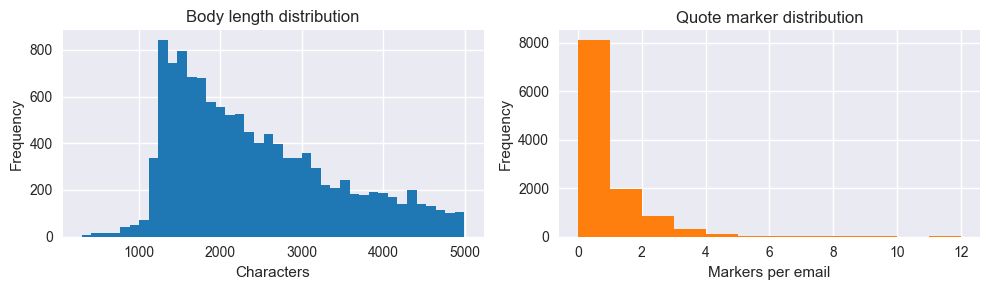

In [17]:
if not filtered_df.empty:
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    filtered_df["body_char_len"].plot(kind="hist", bins=40, ax=axes[0], color="#1f77b4")
    axes[0].set_title("Body length distribution")
    axes[0].set_xlabel("Characters")

    (filtered_df["quote_separator_count"] + filtered_df["quote_line_count"]).plot(
        kind="hist",
        bins=range(0, filtered_df["quote_separator_count"].max() + 3),
        ax=axes[1],
        color="#ff7f0e",
    )
    axes[1].set_title("Quote marker distribution")
    axes[1].set_xlabel("Markers per email")

    plt.tight_layout()
    plt.show()
else:
    print("No emails matched the current filter settings.")

## Review top candidate emails

Inspect a few high-scoring messages to confirm the slice feels right for the workshop.

Use these previews to pick golden examples; export them straight into the labeling notebook.

In [19]:
candidate_df.head()

,file,raw_char_len,subject,normalized_subject,from_raw,from_email,to_raw,to_emails,to_count,cc_raw,cc_emails,cc_count,date_raw,body,body_char_len,body_line_count,quote_separator_count,quote_line_count,action_hit,sent_at,quote_markers
117489,sanchez-m/deleted_items/21.,3578,Fw: Fw: FW: Dr. Seuss (Don't delete,dr. seuss (don't delete,dpriese@worldnet.att.net,dpriese@worldnet.att.net,"tim.deanna@enron.com, cornella.deb@enron.com, tim.dori@enron.com, priese.fred@enron.com, hartwig.jack@enron.com, taylor.mickey@enron.com",tim.deanna@enron.com;cornella.deb@enron.com;tim.dori@enron.com;priese.fred@enron.com;hartwig.jack@enron.com;taylor.mickey@enron.com,6,NaN,NaN,0,"Thu, 31 May 2001 08:39:20 -0700 (PDT)",----- Original Message -----\nFrom: patbelle <patbelle@mail.ev1.net>\nTo: <dpriese@worldnet.att.net>; <marnold2@houston.rr.com>;\n<Gilles.RICHARD5@wanadoo.f...,2540,237,1,226,True,2001-05-31 15:39:20,227
34505,farmer-d/logistics/112.,5492,"Re: FW: FW: 05/01 ENA Gas Sales on HPL, to D & H Gas Company","05/01 ena gas sales on hpl, to d & h gas company",tnray@aep.com,tnray@aep.com,j..farmer@enron.com,j..farmer@enron.com,1,NaN,NaN,0,"Wed, 20 Jun 2001 13:46:49 -0700 (PDT)","Elizabeth,\nHas contract expired? Unable to get deal to come across to Unify\nSettlements.\nThanks!\nTess\n\n\n\n\n ""Farmer, Daren\n ...",4920,189,7,157,True,2001-06-20 20:46:49,164
92219,mann-k/_sent_mail/1401.,5216,Re: Lake Austin Spa Resort,lake austin spa resort,kay.mann@enron.com,kay.mann@enron.com,cindyv@lakeaustin.com,cindyv@lakeaustin.com,1,NaN,NaN,0,"Wed, 7 Mar 2001 02:16:00 -0800 (PST)","I think what I will do is send out an email today to have people call you \ndirectly and reserve a room. We can then see how many short we are, and deal \n...",4759,205,2,157,True,2001-03-07 10:16:00,159
94088,mann-k/all_documents/3934.,5220,Re: Lake Austin Spa Resort,lake austin spa resort,kay.mann@enron.com,kay.mann@enron.com,cindyv@lakeaustin.com,cindyv@lakeaustin.com,1,NaN,NaN,0,"Wed, 7 Mar 2001 02:16:00 -0800 (PST)","I think what I will do is send out an email today to have people call you \ndirectly and reserve a room. We can then see how many short we are, and deal \n...",4759,205,2,157,True,2001-03-07 10:16:00,159
97871,mann-k/sent/2999.,5210,Re: Lake Austin Spa Resort,lake austin spa resort,kay.mann@enron.com,kay.mann@enron.com,cindyv@lakeaustin.com,cindyv@lakeaustin.com,1,NaN,NaN,0,"Wed, 7 Mar 2001 02:16:00 -0800 (PST)","I think what I will do is send out an email today to have people call you \ndirectly and reserve a room. We can then see how many short we are, and deal \n...",4759,205,2,157,True,2001-03-07 10:16:00,159


Rank the filtered emails by conversational depth, then preview a few to confirm they are suitable for the workshop exercises.

## Next steps

- Export `candidate_df` for annotation or golden-set authoring.
- Drop selected emails into the evaluation notebooks to practice the Analyze→Measure→Improve loop.
- Adjust the thresholds (`ACTION_KEYWORDS`, `MAX_RECIPIENTS`, `MIN_QUOTE_MARKERS`, `MAX_BODY_CHARS`) if the balance between context and readability needs tuning.

In [25]:
def render_email(row: pd.Series, body_lines: int = 40) -> None:
    subject = row["subject"] or "(no subject)"
    meta_lines = [
        f"### {subject}",
        f"- File: `{row['file']}`",
        f"- From: {row.get('from_email') or row.get('from_raw') or 'unknown'}",
        f"- To: {row.get('to_emails') or row.get('to_raw') or '—'}",
        f"- CC: {row.get('cc_emails') or row.get('cc_raw') or '—'}",
        f"- Sent: {row['sent_at']:%Y-%m-%d %H:%M}"
        if pd.notna(row["sent_at"])
        else "- Sent: unknown",
        f"- Characters: {row['body_char_len']:,}",
        f"- Quote markers: {row['quote_separator_count'] + row['quote_line_count']:,}",
    ]
    body_lines_list = row["body"].splitlines()
    body_preview = "\n".join(body_lines_list[:body_lines]).strip()
    if len(body_lines_list) > body_lines:
        body_preview += "\n..."
    markdown = "\n\n".join(meta_lines) + f"\n\n```\n{body_preview}\n```"
    display(Markdown(markdown))


if not filtered_df.empty:
    top_rows = (
        candidate_df.assign(
            quote_markers=lambda df: df["quote_separator_count"]
            + df["quote_line_count"]
        )
        .sort_values(["quote_markers", "body_char_len"], ascending=[False, False])
        .head(100)[97:98]  # Show the 101st email for variety
    )
    for _, row in top_rows.iterrows():
        render_email(row, 1000)
else:
    print("No emails available to preview.")

### Re: Visiting Enron May 4th

- File: `kaminski-v/all_documents/710.`

- From: vince.kaminski@enron.com

- To: susan.hansen@stanford.edu

- CC: vince.kaminski@enron.com

- Sent: 2001-04-09 11:18

- Characters: 3,017

- Quote markers: 70

```
Susan,

Thanks. It makes sense to call Christie and
explain the objectives of your visit in May.

Vince





"Susan C. Hansen" <susan.hansen@stanford.edu> on 04/06/2001 06:14:10 PM
To: Vince.J.Kaminski@enron.com
cc: clovell@stanford.edu, donna Lawrence <donna.lawrence@stanford.edu>, 
hillh@stanford.edu, bambos@stanford.edu 
Subject: Visiting Enron May 4th


Dear Vince,

this is great news!  Donna and I are delighted that you have time to see us
on May 4th.

I'll be out of the office next week.  By copy of this email to my
assistant, Carol Lovell, I will ask her to get in touch with Shirley for
scheduling as well as directions on where to meet you.  We'll be glad to
meet with Christie Patrick as well.

Looking forward to meeting you,

Susan


At 05:36 PM 4/6/01 -0500, you wrote:

>Susan,
>
>Thank you for your message. I shall be glad to meet with you on May the
>4th.
>I shall ask my assistant, Shirley Crenshaw (713) 853 5290, to call you to
>set up the meeting.
>
>Also, for your information, we have recently set up a special unit to
>coordinate Enron's
>relationships with the universities. The person running this unit is
>Christie Patrick.
>Please, feel free to contact her and give my name as a reference. I shall
>coordinate the meeting
>on May  the 4th with her.
>
>Vince
>
>
>Additional information re Christie:
>
>Phone :      (713) 853-6117
>
>Email:         christie_patrick@enron.com
>
>
>
>
>
>"Susan C. Hansen" <susan.hansen@stanford.edu> on 04/03/2001 04:33:54 PM
>
>To:   vkamins@enron.com
>cc:
>Subject:  Visit from Stanford?
>
>
>Dear Dr. Kaminski,
>
>Let me briefly introduce myself, I am the Director of Corporate Relations
>for the School of Engineering at Stanford University.  In this role, I am
>always on the watch for ways to bring our faculty together with companies
>that have an appetite for engagement with top tier research institutions.
>
>I believe you know Hill Huntington, who is a senior researcher with
>Stanford's Energy Modeling Forum.  He suggested I get in touch with you for
>some ideas about contacts at Enron.  I'm in the process of planning a trip
>to Texas in early May along with my colleague Donna Lawrence, the
>university's Director of Corporate Relations.  We were hoping to be able to
>include a stop at Enron on our itinerary. Right now it appears that Friday,
>May 4th would work best for us but we're at the very beginning of our trip
>planning.
>
>The purpose of our visit would be to review the current relationship
>between Enron and Stanford, to give you an overview of current priorities
>in the School of Engineering, and ask for your help in identifying the best
>points of contact.
>
>I look forward to hearing from you about your availability,
>
>Sincerely,
>Susan Hansen
>
>
>
>
>Susan C. Hansen
>Director, Corporate Relations
>School of Engineering
>Stanford University
>Stanford, CA 94305-4027
>(650) 725-4219

Susan C. Hansen
Director, Corporate Relations
School of Engineering
Stanford University
Stanford, CA 94305-4027
(650) 725-4219
```

In [17]:
candidate_df["body_char_len"].describe()

count    12615.000000
mean      2401.745700
std        994.239697
min        296.000000
25%       1579.000000
50%       2174.000000
75%       3035.000000
max       4999.000000
Name: body_char_len, dtype: float64

In [26]:
candidate_df.shape

(12020, 21)

In [27]:
candidate_df.to_csv("../data/filtered_emails.csv", index=False)
print("Filtered emails saved to filtered_emails.csv")

Filtered emails saved to filtered_emails.csv


In [2]:
candidate_df = pd.read_csv("../data/filtered_emails.csv")

In [4]:
candidate_df.shape
candidate_df.sample(30).to_csv("../data/sample_filtered_emails_sample.csv", index=False)